In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

# If needed: load .env (notebooks/ -> project root)
load_dotenv(Path("..") / ".env")

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASSWORD")

assert DB_HOST and DB_NAME and DB_USER, "Missing DB vars (DB_HOST/DB_NAME/DB_USER)"
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

def q(sql: str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

print("Connected OK")


Connected OK


In [2]:
CREAT_ITEMID = 50912  # confirmed by you

sql_target_trial = f"""
WITH aki_hadm AS (
  SELECT DISTINCT hadm_id
  FROM diagnoses_icd
  WHERE icd9_code LIKE '584%'
),

cohort AS (
  SELECT
    i.subject_id,
    i.hadm_id,
    i.icustay_id,
    i.intime,
    i.first_careunit,
    (i.intime + interval '24 hour') AS landmark_time
  FROM icustays i
  JOIN aki_hadm a ON a.hadm_id = i.hadm_id
),

-- Demographics
demo AS (
  SELECT
    c.icustay_id,
    a.hospital_expire_flag::int AS hospital_mortality,
    p.gender,
    a.admission_type,
    EXTRACT(YEAR FROM a.admittime) - EXTRACT(YEAR FROM p.dob) 
      - CASE WHEN (EXTRACT(MONTH FROM a.admittime), EXTRACT(DAY FROM a.admittime))
              < (EXTRACT(MONTH FROM p.dob), EXTRACT(DAY FROM p.dob))
             THEN 1 ELSE 0 END AS age
  FROM cohort c
  JOIN admissions a ON a.hadm_id = c.hadm_id
  JOIN patients p ON p.subject_id = c.subject_id
),

-- Creatinine labs during baseline window (-24h to +24h around ICU intime)
creat AS (
  SELECT
    c.icustay_id,
    l.charttime,
    l.valuenum AS creat
  FROM cohort c
  JOIN labevents l ON l.hadm_id = c.hadm_id
  WHERE l.itemid = {CREAT_ITEMID}
    AND l.valuenum IS NOT NULL
    AND l.charttime BETWEEN c.intime - interval '24 hour' AND c.landmark_time
),

baseline_creat AS (
  SELECT icustay_id, MIN(creat) AS baseline_creat
  FROM creat
  GROUP BY icustay_id
),

peak_creat_24h AS (
  SELECT icustay_id, MAX(creat) AS peak_creat_24h
  FROM creat
  GROUP BY icustay_id
),

-- Early vasopressors: any vasopressor started within first 24h
vaso AS (
  SELECT DISTINCT
    c.icustay_id,
    1 AS early_vaso
  FROM cohort c
  JOIN inputevents_mv ie ON ie.icustay_id = c.icustay_id
  LEFT JOIN d_items di ON di.itemid = ie.itemid
  WHERE ie.starttime <= c.landmark_time
    AND (
      LOWER(COALESCE(di.label,'')) LIKE '%norepi%' OR LOWER(COALESCE(di.label,'')) LIKE '%noradren%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%levophed%' OR LOWER(COALESCE(di.label,'')) = 'ne'
      OR LOWER(COALESCE(di.label,'')) LIKE '%vasopress%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%epine%' OR LOWER(COALESCE(di.label,'')) LIKE '%adrenalin%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%phenyleph%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%dopamine%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%dobutamine%'
    )
),

-- Early mechanical ventilation within 24h (proxy severity)
early_vent AS (
  SELECT DISTINCT
    c.icustay_id,
    1 AS early_vent
  FROM cohort c
  JOIN procedureevents_mv pe ON pe.icustay_id = c.icustay_id
  LEFT JOIN d_items di ON di.itemid = pe.itemid
  WHERE pe.starttime <= c.landmark_time
    AND (
      LOWER(COALESCE(di.label,'')) LIKE '%vent%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%intubat%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%respirat%'
    )
),

-- Early fluids within 24h (proxy severity + resuscitation)
early_fluids AS (
  SELECT DISTINCT
    c.icustay_id,
    1 AS early_fluids
  FROM cohort c
  JOIN inputevents_mv ie ON ie.icustay_id = c.icustay_id
  LEFT JOIN d_items di ON di.itemid = ie.itemid
  WHERE ie.starttime <= c.landmark_time
    AND (
      LOWER(COALESCE(di.label,'')) LIKE '%nacl%' OR LOWER(COALESCE(di.label,'')) LIKE '%normal saline%' OR LOWER(COALESCE(di.label,'')) = 'ns'
      OR LOWER(COALESCE(di.label,'')) LIKE '%0.9%' OR LOWER(COALESCE(di.label,'')) LIKE '%0.45%' OR LOWER(COALESCE(di.label,'')) LIKE '%1/2ns%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%d5 1/2ns%' OR LOWER(COALESCE(di.label,'')) LIKE '%half ns%'
      OR LOWER(COALESCE(di.label,'')) = 'lr' OR LOWER(COALESCE(di.label,'')) LIKE '%lactated%' OR LOWER(COALESCE(di.label,'')) LIKE '%ringer%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%dextrose%' OR LOWER(COALESCE(di.label,'')) LIKE '%d5w%' OR LOWER(COALESCE(di.label,'')) LIKE '%d10w%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%sterile water%' OR LOWER(COALESCE(di.label,'')) LIKE '%free water%'
      OR LOWER(COALESCE(di.label,'')) LIKE '%plasma-lyte%' OR LOWER(COALESCE(di.label,'')) LIKE '%plasmalyte%'
    )
    AND LOWER(COALESCE(di.label,'')) NOT LIKE '%po intake%'
    AND LOWER(COALESCE(di.label,'')) NOT LIKE '%pre-admission intake%'
    AND LOWER(COALESCE(di.label,'')) NOT LIKE '%solution%'
    AND LOWER(COALESCE(di.label,'')) NOT LIKE '%piggyback%'
)

SELECT
  c.subject_id,
  c.hadm_id,
  c.icustay_id,
  d.hospital_mortality,
  d.gender,
  CASE WHEN d.gender = 'F' THEN 1 ELSE 0 END AS female,
  d.admission_type,
  c.first_careunit,
  CASE WHEN d.age > 89 THEN 90 ELSE d.age END AS age, -- MIMIC age cap
  COALESCE(b.baseline_creat, NULL) AS baseline_creat,
  COALESCE(p.peak_creat_24h, NULL) AS peak_creat_24h,
  COALESCE(v.early_vaso, 0) AS early_vaso,
  COALESCE(ev.early_vent, 0) AS early_vent,
  COALESCE(ef.early_fluids, 0) AS early_fluids
FROM cohort c
JOIN demo d ON d.icustay_id = c.icustay_id
LEFT JOIN baseline_creat b ON b.icustay_id = c.icustay_id
LEFT JOIN peak_creat_24h p ON p.icustay_id = c.icustay_id
LEFT JOIN vaso v ON v.icustay_id = c.icustay_id
LEFT JOIN early_vent ev ON ev.icustay_id = c.icustay_id
LEFT JOIN early_fluids ef ON ef.icustay_id = c.icustay_id;
"""

df_tt = q(sql_target_trial)
df_tt.head()


,subject_id,hadm_id,icustay_id,hospital_mortality,gender,female,admission_type,first_careunit,age,baseline_creat,peak_creat_24h,early_vaso,early_vent,early_fluids
0,29035,119860,235102,0,F,1,EMERGENCY,MICU,65.0,1.2,1.7,1,1,1
1,7585,176005,297372,0,M,0,EMERGENCY,CCU,73.0,3.9,7.0,0,0,1
2,94564,187397,278542,0,M,0,EMERGENCY,MICU,57.0,1.1,1.6,1,0,1
3,75582,108993,238172,0,M,0,EMERGENCY,TSICU,69.0,1.2,1.2,0,0,1
4,52109,179978,290564,0,F,1,EMERGENCY,SICU,90.0,1.6,1.6,0,1,1


In [3]:
print("Rows (ICU-stays):", len(df_tt))
print("Early vaso rate:", df_tt["early_vaso"].mean())
print("Mortality rate:", df_tt["hospital_mortality"].mean())

# Missingness
df_tt[["baseline_creat","peak_creat_24h"]].isna().mean()


Rows (ICU-stays): 12879
Early vaso rate: 0.16328907523876077
Mortality rate: 0.2343349638947123


baseline_creat    0.005513
peak_creat_24h    0.005513
dtype: float64

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

df = df_tt.copy()

# Missing indicators + median imputation for creatinine
for col in ["baseline_creat", "peak_creat_24h"]:
    df[col + "_missing"] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

y_treat = df["early_vaso"].astype(int)
y_outcome = df["hospital_mortality"].astype(int)

# Covariates measured pre-landmark (keep it strict)
num_cols = ["age", "baseline_creat", "peak_creat_24h", "early_vent", "early_fluids",
            "baseline_creat_missing", "peak_creat_24h_missing"]
cat_cols = ["female", "admission_type", "first_careunit"]

X = df[num_cols + cat_cols]


In [5]:
# Build PS model: P(T=1 | X)
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

ps_model = Pipeline(steps=[
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

ps_model.fit(X, y_treat)
ps = ps_model.predict_proba(X)[:, 1]

# Stabilized IPTW
p_treat = y_treat.mean()
w = np.where(y_treat == 1, p_treat / ps, (1 - p_treat) / (1 - ps))

# Truncate extreme weights (common, improves stability)
w_trunc = np.clip(w, np.quantile(w, 0.01), np.quantile(w, 0.99))

df["ps"] = ps
df["w"] = w_trunc

df[["ps","w"]].describe()


,ps,w
count,12879.000000,12879.000000
mean,0.163297,0.908575
std,0.218676,0.357336
min,0.000172,0.219741
25%,0.000692,0.837196
50%,0.001960,0.837421
75%,0.200556,0.995426
max,0.962206,2.230168


In [6]:
def weighted_mean(a, w):
    a = np.asarray(a, dtype=float)
    w = np.asarray(w, dtype=float)
    return np.sum(a*w)/np.sum(w)

treated = (df["early_vaso"] == 1).values
y = df["hospital_mortality"].values
w = df["w"].values

risk_t = weighted_mean(y[treated], w[treated])
risk_c = weighted_mean(y[~treated], w[~treated])

rd = risk_t - risk_c
rr = risk_t / risk_c if risk_c > 0 else np.nan

print("Weighted risk treated:", risk_t)
print("Weighted risk control:", risk_c)
print("Risk difference (T-C):", rd)
print("Risk ratio (T/C):", rr)


Weighted risk treated: 0.29554992138412484
Weighted risk control: 0.2142573039268959
Risk difference (T-C): 0.08129261745722893
Risk ratio (T/C): 1.3794158517226829


In [7]:
def subgroup_effect(df_sub):
    t = (df_sub["early_vaso"] == 1).values
    y = df_sub["hospital_mortality"].values
    w = df_sub["w"].values
    rt = weighted_mean(y[t], w[t])
    rc = weighted_mean(y[~t], w[~t])
    return pd.Series({
        "n": len(df_sub),
        "risk_t": rt,
        "risk_c": rc,
        "rd": rt-rc,
        "rr": rt/rc if rc>0 else np.nan
    })

res_sex = pd.concat([
    subgroup_effect(df[df["female"]==1]).rename("female"),
    subgroup_effect(df[df["female"]==0]).rename("male"),
], axis=1).T

res_sex


,n,risk_t,risk_c,rd,rr
female,5467.0,0.302428,0.211870,0.090558,1.427425
male,7412.0,0.290173,0.216043,0.074130,1.343126


In [8]:
def stage_kdigo_24h(baseline, peak):
    if pd.isna(baseline) or pd.isna(peak):
        return np.nan
    if peak >= 4.0 or peak >= 3.0 * baseline:
        return 3
    if peak >= 2.0 * baseline:
        return 2
    if peak >= 1.5 * baseline or (peak - baseline) >= 0.3:
        return 1
    return 0

df["aki_stage_24h"] = [stage_kdigo_24h(b,p) for b,p in zip(df["baseline_creat"], df["peak_creat_24h"])]
df["aki_stage_24h"].value_counts(dropna=False).sort_index()


aki_stage_24h
0    5220
1    5238
2     662
3    1759
Name: count, dtype: int64

In [9]:
res_stage = df.dropna(subset=["aki_stage_24h"]).groupby("aki_stage_24h").apply(subgroup_effect)
res_stage


C:\Users\Simon\AppData\Local\Temp\ipykernel_25720\3439488360.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res_stage = df.dropna(subset=["aki_stage_24h"]).groupby("aki_stage_24h").apply(subgroup_effect)


,n,risk_t,risk_c,rd,rr
aki_stage_24h,,,,,
0,5220.0,0.310262,0.216092,0.094170,1.435786
1,5238.0,0.276810,0.212399,0.064411,1.303254
2,662.0,0.187490,0.191871,-0.004381,0.977166
3,1759.0,0.362656,0.222197,0.140459,1.632140


In [10]:
import numpy as np
import pandas as pd

# df = dein fertiges DataFrame aus der IPTW-Pipeline (mit ps, w, aki_stage_24h etc.)

cols = [
    "hospital_mortality",
    "early_vaso",
    "female",
    "age",
    "baseline_creat",
    "peak_creat_24h",
    "early_vent",
    "early_fluids",
    "aki_stage_24h",
    "ps",
    "w"
]

# nur Spalten nehmen, die existieren
cols = [c for c in cols if c in df.columns]
df_corr = df[cols].copy()

# sicherstellen: alles numerisch
for c in df_corr.columns:
    df_corr[c] = pd.to_numeric(df_corr[c], errors="coerce")

df_corr.head()


,hospital_mortality,early_vaso,female,age,baseline_creat,peak_creat_24h,early_vent,early_fluids,aki_stage_24h,ps,w
0,0,1,1,65.0,1.2,1.7,1,1,1,0.516687,0.316031
1,0,0,0,73.0,3.9,7.0,0,1,3,0.329483,1.247859
2,0,1,0,57.0,1.1,1.6,0,1,1,0.145869,1.119421
3,0,0,0,69.0,1.2,1.2,0,1,0,0.171103,1.009427
4,0,0,1,90.0,1.6,1.6,1,1,0,0.544485,1.836848


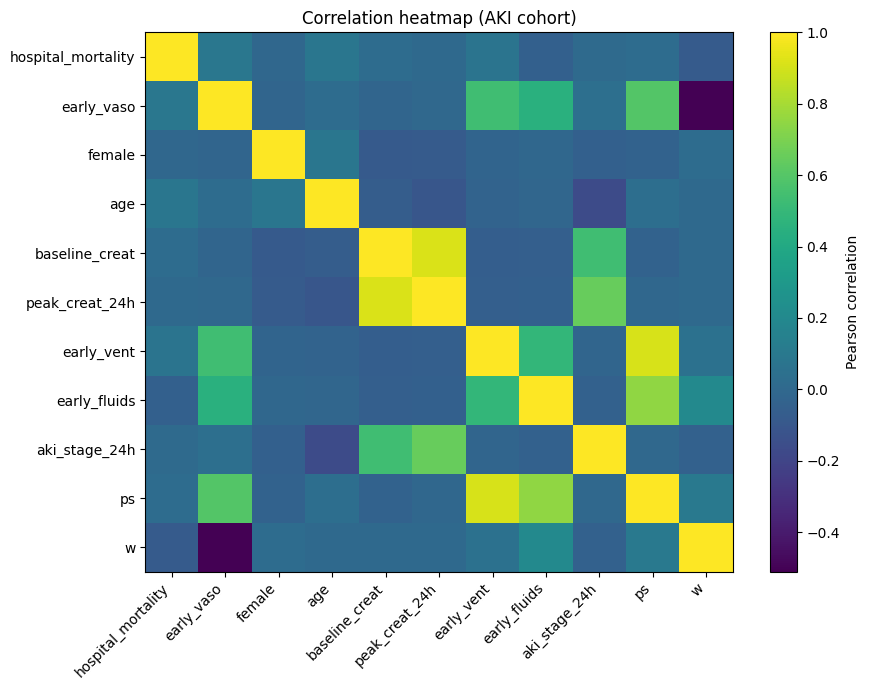

In [11]:
import matplotlib.pyplot as plt

corr = df_corr.corr(method="pearson")

plt.figure(figsize=(9, 7))
plt.imshow(corr.values, aspect="auto")
plt.colorbar(label="Pearson correlation")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation heatmap (AKI cohort)")
plt.tight_layout()
plt.show()


In [12]:
mort = corr["hospital_mortality"].drop("hospital_mortality").sort_values(key=lambda s: s.abs(), ascending=False)
mort.to_frame("corr_with_mortality")


,corr_with_mortality
early_vaso,0.087874
age,0.082089
w,-0.077029
early_vent,0.068639
early_fluids,-0.049913
baseline_creat,0.026637
ps,0.023146
aki_stage_24h,0.012250
peak_creat_24h,0.007205
female,-0.006716


In [13]:
from sqlalchemy import text

sql_create_charlson = """
CREATE OR REPLACE VIEW charlson_hadm AS
WITH dx AS (
  SELECT DISTINCT hadm_id, icd9_code
  FROM diagnoses_icd
),
flags AS (
  SELECT
    hadm_id,

    -- Myocardial infarction
    MAX(CASE WHEN icd9_code LIKE '410%' OR icd9_code LIKE '412%' THEN 1 ELSE 0 END) AS mi,

    -- Congestive heart failure
    MAX(CASE WHEN icd9_code LIKE '428%' THEN 1 ELSE 0 END) AS chf,

    -- Peripheral vascular disease
    MAX(CASE WHEN icd9_code LIKE '440%' OR icd9_code LIKE '441%' OR icd9_code LIKE '4439%' OR icd9_code LIKE '7854%' OR icd9_code LIKE 'V434%' THEN 1 ELSE 0 END) AS pvd,

    -- Cerebrovascular disease
    MAX(CASE WHEN icd9_code LIKE '430%' OR icd9_code LIKE '431%' OR icd9_code LIKE '432%' OR icd9_code LIKE '433%' OR icd9_code LIKE '434%' OR icd9_code LIKE '435%' OR icd9_code LIKE '436%' OR icd9_code LIKE '437%' OR icd9_code LIKE '438%' THEN 1 ELSE 0 END) AS cva,

    -- Dementia
    MAX(CASE WHEN icd9_code LIKE '290%' OR icd9_code LIKE '2941%' OR icd9_code LIKE '3312%' THEN 1 ELSE 0 END) AS dementia,

    -- Chronic pulmonary disease
    MAX(CASE WHEN icd9_code LIKE '490%' OR icd9_code LIKE '491%' OR icd9_code LIKE '492%' OR icd9_code LIKE '493%' OR icd9_code LIKE '494%' OR icd9_code LIKE '495%' OR icd9_code LIKE '496%' THEN 1 ELSE 0 END) AS copd,

    -- Rheumatic disease
    MAX(CASE WHEN icd9_code LIKE '7100%' OR icd9_code LIKE '7101%' OR icd9_code LIKE '7104%' OR icd9_code LIKE '714%' OR icd9_code LIKE '725%' THEN 1 ELSE 0 END) AS rheum,

    -- Peptic ulcer disease
    MAX(CASE WHEN icd9_code LIKE '531%' OR icd9_code LIKE '532%' OR icd9_code LIKE '533%' OR icd9_code LIKE '534%' THEN 1 ELSE 0 END) AS pud,

    -- Mild liver disease
    MAX(CASE WHEN icd9_code LIKE '5712%' OR icd9_code LIKE '5714%' OR icd9_code LIKE '5715%' OR icd9_code LIKE '5716%' THEN 1 ELSE 0 END) AS mild_liver,

    -- Diabetes (uncomplicated)
    MAX(CASE WHEN icd9_code LIKE '2500%' OR icd9_code LIKE '2501%' OR icd9_code LIKE '2502%' OR icd9_code LIKE '2503%' THEN 1 ELSE 0 END) AS dm_uncomp,

    -- Diabetes with chronic complications
    MAX(CASE WHEN icd9_code LIKE '2504%' OR icd9_code LIKE '2505%' OR icd9_code LIKE '2506%' OR icd9_code LIKE '2507%' OR icd9_code LIKE '2508%' OR icd9_code LIKE '2509%' THEN 1 ELSE 0 END) AS dm_comp,

    -- Hemiplegia/paraplegia
    MAX(CASE WHEN icd9_code LIKE '342%' OR icd9_code LIKE '343%' OR icd9_code LIKE '3441%' THEN 1 ELSE 0 END) AS hemi,

    -- Renal disease (chronic kidney disease etc.)
    MAX(CASE WHEN icd9_code LIKE '582%' OR icd9_code LIKE '583%' OR icd9_code LIKE '585%' OR icd9_code LIKE '586%' OR icd9_code LIKE '588%' THEN 1 ELSE 0 END) AS renal,

    -- Any malignancy (incl lymphoma/leukemia, exclude metastatic)
    MAX(CASE WHEN (icd9_code >= '140' AND icd9_code <= '172')
              OR (icd9_code >= '174' AND icd9_code <= '195')
              OR (icd9_code >= '200' AND icd9_code <= '208')
             THEN 1 ELSE 0 END) AS malignancy,

    -- Moderate/severe liver disease
    MAX(CASE WHEN icd9_code LIKE '5722%' OR icd9_code LIKE '5723%' OR icd9_code LIKE '5724%' OR icd9_code LIKE '5728%' THEN 1 ELSE 0 END) AS severe_liver,

    -- Metastatic solid tumor
    MAX(CASE WHEN icd9_code LIKE '196%' OR icd9_code LIKE '197%' OR icd9_code LIKE '198%' OR icd9_code LIKE '199%' THEN 1 ELSE 0 END) AS mets,

    -- AIDS/HIV
    MAX(CASE WHEN icd9_code LIKE '042%' OR icd9_code LIKE '043%' OR icd9_code LIKE '044%' THEN 1 ELSE 0 END) AS aids
  FROM dx
  GROUP BY hadm_id
)
SELECT
  hadm_id,
  (
    1*mi + 1*chf + 1*pvd + 1*cva + 1*dementia + 1*copd + 1*rheum + 1*pud + 1*mild_liver
    + 1*dm_uncomp + 2*dm_comp + 2*hemi + 2*renal + 2*malignancy + 3*severe_liver + 6*mets + 6*aids
  ) AS charlson
FROM flags;
"""

with engine.begin() as conn:
    conn.execute(text(sql_create_charlson))

print("Created view: charlson_hadm")


Created view: charlson_hadm


In [14]:
df_charlson = q("""
SELECT hadm_id, charlson
FROM charlson_hadm;
""")

df = df.merge(df_charlson, on="hadm_id", how="left")
df["charlson"] = df["charlson"].fillna(0).astype(int)
df[["charlson"]].describe()


,charlson
count,12879.000000
mean,3.348086
std,2.513707
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,18.000000


In [15]:
# Find itemids robustly
df_lab_items = q("""
SELECT itemid, label
FROM d_labitems
WHERE LOWER(label) IN ('platelet count','bilirubin','bilirubin, total','bilirubin total')
   OR LOWER(label) LIKE '%platelet%'
   OR LOWER(label) LIKE '%bilirubin%'
ORDER BY itemid;
""")
df_lab_items.head(20)


,itemid,label
0,50838,"Bilirubin, Total, Ascites"
1,50883,"Bilirubin, Direct"
2,50884,"Bilirubin, Indirect"
3,50885,"Bilirubin, Total"
4,51012,"Bilirubin, Total, CSF"
5,51028,"Bilirubin, Total, Body Fluid"
6,51049,"Bilirubin, Total, Pleural"
7,51240,Large Platelets
8,51264,Platelet Clumps
9,51265,Platelet Count


In [16]:
PLT_ITEMID = 51265   # häufig Platelet Count
BILI_ITEMID = 50885  # häufig Bilirubin, Total

sql_sofa_labs_24h = f"""
WITH cohort AS (
  SELECT subject_id, hadm_id, icustay_id, intime, (intime + interval '24 hour') AS t24
  FROM icustays
),
labs AS (
  SELECT
    c.icustay_id,
    l.itemid,
    l.valuenum
  FROM cohort c
  JOIN labevents l
    ON l.hadm_id = c.hadm_id
   AND l.charttime BETWEEN c.intime AND c.t24
  WHERE l.valuenum IS NOT NULL
    AND l.itemid IN ({PLT_ITEMID}, {BILI_ITEMID})
)
SELECT
  icustay_id,
  MIN(CASE WHEN itemid = {PLT_ITEMID} THEN valuenum END) AS platelets_min_24h,
  MAX(CASE WHEN itemid = {BILI_ITEMID} THEN valuenum END) AS bili_max_24h
FROM labs
GROUP BY icustay_id;
"""

df_sofa_labs = q(sql_sofa_labs_24h)
df_sofa_labs.head()


,icustay_id,platelets_min_24h,bili_max_24h
0,200001,128.0,0.2
1,200003,109.0,3.9
2,200006,162.0,NaN
3,200007,247.0,NaN
4,200009,81.0,NaN


In [17]:
df = df.merge(df_sofa_labs, on="icustay_id", how="left")

# Missing indicators + median fill (project-safe)
for col in ["platelets_min_24h", "bili_max_24h"]:
    df[col + "_missing"] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

def sofa_coag_platelets(plt):
    # SOFA coagulation points by platelets (x10^3/uL)
    if plt < 20: return 4
    if plt < 50: return 3
    if plt < 100: return 2
    if plt < 150: return 1
    return 0

def sofa_liver_bili(bili):
    # SOFA liver points by total bilirubin (mg/dL)
    if bili >= 12: return 4
    if bili >= 6:  return 3
    if bili >= 2:  return 2
    if bili >= 1.2:return 1
    return 0

def sofa_renal_creat(creat):
    # SOFA renal points by creatinine (mg/dL), urine output ignored in this approx
    if creat >= 5.0: return 4
    if creat >= 3.5: return 3
    if creat >= 2.0: return 2
    if creat >= 1.2: return 1
    return 0

# Approx respiration + cardio using your early flags
# respiration: 2 points if ventilated early (rough proxy)
# cardio: 2 points if on vasopressor early (rough proxy)
df["sofa_coag_24h"] = df["platelets_min_24h"].apply(sofa_coag_platelets)
df["sofa_liver_24h"] = df["bili_max_24h"].apply(sofa_liver_bili)
df["sofa_renal_24h"] = df["peak_creat_24h"].apply(sofa_renal_creat)  # worst creat in first 24h
df["sofa_resp_24h"] = df["early_vent"].astype(int) * 2
df["sofa_cv_24h"] = df["early_vaso"].astype(int) * 2

df["sofa_approx_24h"] = (
    df["sofa_coag_24h"] +
    df["sofa_liver_24h"] +
    df["sofa_renal_24h"] +
    df["sofa_resp_24h"] +
    df["sofa_cv_24h"]
)

df[["sofa_approx_24h","sofa_coag_24h","sofa_liver_24h","sofa_renal_24h","sofa_resp_24h","sofa_cv_24h"]].describe()


,sofa_approx_24h,sofa_coag_24h,sofa_liver_24h,sofa_renal_24h,sofa_resp_24h,sofa_cv_24h
count,12879.000000,12879.000000,12879.000000,12879.000000,12879.000000,12879.000000
mean,3.356161,0.600668,0.455237,1.589642,0.384036,0.326578
std,2.473454,0.948644,0.998288,1.070589,0.787805,0.739287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,2.000000,0.000000,0.000000
max,15.000000,4.000000,4.000000,4.000000,2.000000,2.000000


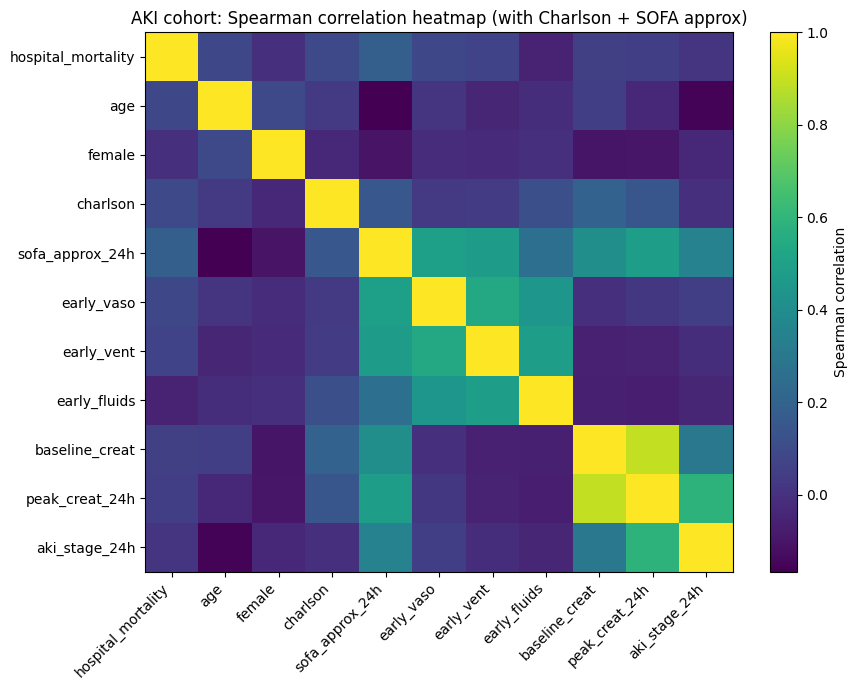

,spearman_with_mortality
sofa_approx_24h,0.187365
charlson,0.089427
early_vaso,0.087874
age,0.085422
early_vent,0.068639
baseline_creat,0.056620
early_fluids,-0.049913
peak_creat_24h,0.048323
aki_stage_24h,0.008189
female,-0.006716


In [18]:
import matplotlib.pyplot as plt

cols = [
    "hospital_mortality",
    "age",
    "female",
    "charlson",
    "sofa_approx_24h",
    "early_vaso",
    "early_vent",
    "early_fluids",
    "baseline_creat",
    "peak_creat_24h",
    "aki_stage_24h"
]
cols = [c for c in cols if c in df.columns]

df_corr = df[cols].copy()
for c in df_corr.columns:
    df_corr[c] = pd.to_numeric(df_corr[c], errors="coerce")

corr = df_corr.corr(method="spearman")  # Spearman robust for binary/ordinal

plt.figure(figsize=(9, 7))
plt.imshow(corr.values, aspect="auto")
plt.colorbar(label="Spearman correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("AKI cohort: Spearman correlation heatmap (with Charlson + SOFA approx)")
plt.tight_layout()
plt.show()

mort = corr["hospital_mortality"].drop("hospital_mortality").sort_values(key=lambda s: s.abs(), ascending=False)
mort.to_frame("spearman_with_mortality")


In [19]:
import pandas as pd
import numpy as np

# Kopie für Regression
df_reg = df.copy()

# Outcome
y = df_reg["hospital_mortality"].astype(int)

# Features (bewusst gewählt)
features = [
    "early_vaso",
    "sofa_approx_24h",
    "charlson",
    "age",
    "female",
    "early_vent",
    "early_fluids"
]

X = df_reg[features].copy()

# einfache Sicherheit: fehlende Werte
X = X.fillna(X.median())

X.head()


,early_vaso,sofa_approx_24h,charlson,age,female,early_vent,early_fluids
0,1,5,3,65.0,1,1,1
1,0,5,5,73.0,0,0,1
2,1,8,5,57.0,0,0,1
3,0,4,0,69.0,0,0,1
4,0,5,4,90.0,1,1,1


In [21]:
from sklearn.linear_model import LogisticRegression

# L2-regularisierte logistische Regression
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=2000
)

logreg.fit(X, y)


c:\Users\Simon\Documents\Studium\5_Semester\DataTypes\ehr-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass`

In [22]:
coef = pd.Series(
    logreg.coef_[0],
    index=features,
    name="log_odds"
)

or_table = pd.DataFrame({
    "log_odds": coef,
    "OR": np.exp(coef)
})

or_table.sort_values("OR", ascending=False)


,log_odds,OR
sofa_approx_24h,0.259119,1.295788
charlson,0.078496,1.081659
female,0.057726,1.059425
early_vaso,0.043865,1.044842
early_vent,0.043272,1.044222
age,0.023060,1.023328
early_fluids,-0.743359,0.475514


In [23]:
from sklearn.utils import resample

rng = np.random.default_rng(42)

B = 300  # Bootstrap-Replikate
coefs_boot = []

for _ in range(B):
    idx = rng.choice(len(X), size=len(X), replace=True)
    Xb = X.iloc[idx]
    yb = y.iloc[idx]

    m = LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000
    )
    m.fit(Xb, yb)
    coefs_boot.append(m.coef_[0])

coefs_boot = np.array(coefs_boot)

ci_lower = np.percentile(coefs_boot, 2.5, axis=0)
ci_upper = np.percentile(coefs_boot, 97.5, axis=0)

or_ci = pd.DataFrame({
    "OR": np.exp(coef.values),
    "OR_2.5%": np.exp(ci_lower),
    "OR_97.5%": np.exp(ci_upper)
}, index=features)

or_ci.sort_values("OR", ascending=False)


c:\Users\Simon\Documents\Studium\5_Semester\DataTypes\ehr-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Simon\Documents\Studium\5_Semester\DataTypes\ehr-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Simon\Documents\Studium\5_Semester\DataTypes\ehr-project\.venv\Lib\site-packages\sklearn\linear_model\_

,OR,OR_2.5%,OR_97.5%
sofa_approx_24h,1.295788,1.267327,1.324108
charlson,1.081659,1.061573,1.100860
female,1.059425,0.969558,1.149637
early_vaso,1.044842,0.903473,1.232029
early_vent,1.044222,0.915111,1.186026
age,1.023328,1.020127,1.026217
early_fluids,0.475514,0.426590,0.533095
